# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [381]:
# Importar librerias

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
# Cargar el archivo
df = pd.read_csv('/datasets/taxi.csv')

In [383]:
# Mostrar las primeras filas y la información general del DataFrame
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


(              datetime  num_orders
 0  2018-03-01 00:00:00           9
 1  2018-03-01 00:10:00          14
 2  2018-03-01 00:20:00          28
 3  2018-03-01 00:30:00          20
 4  2018-03-01 00:40:00          32,
 None)

In [384]:
# Remuestreo a intervalos de una hora
# Convertir la columna 'datetime' a tipo datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Establecer como índice
df.set_index('datetime', inplace=True)

# Remuestrear a intervalos de una hora sumando los pedidos
df_hourly = df.resample('1h').sum()

# Ver los primeros resultados
print(df_hourly.head())
print(df_hourly.shape)
print(df_hourly.index.dtype)

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
(4416, 1)
datetime64[ns]


## Análisis

In [385]:
# Verificar varlores faltantes y duplicados.
print(df_hourly.isnull().sum())
print(df_hourly.duplicated().sum())

num_orders    0
dtype: int64
4165


Observación: No se encontraron valores nulos o duplicados.

**Comportamiento de los datos antes de construir el modelo.**

Obtener una comprensión profunda de los datos de pedidos de taxis remuestreados por hora. Esto permite identificar patrones, tendencias y posibles problemas en los datos que pueden influir en la selección y el rendimiento del modelo.

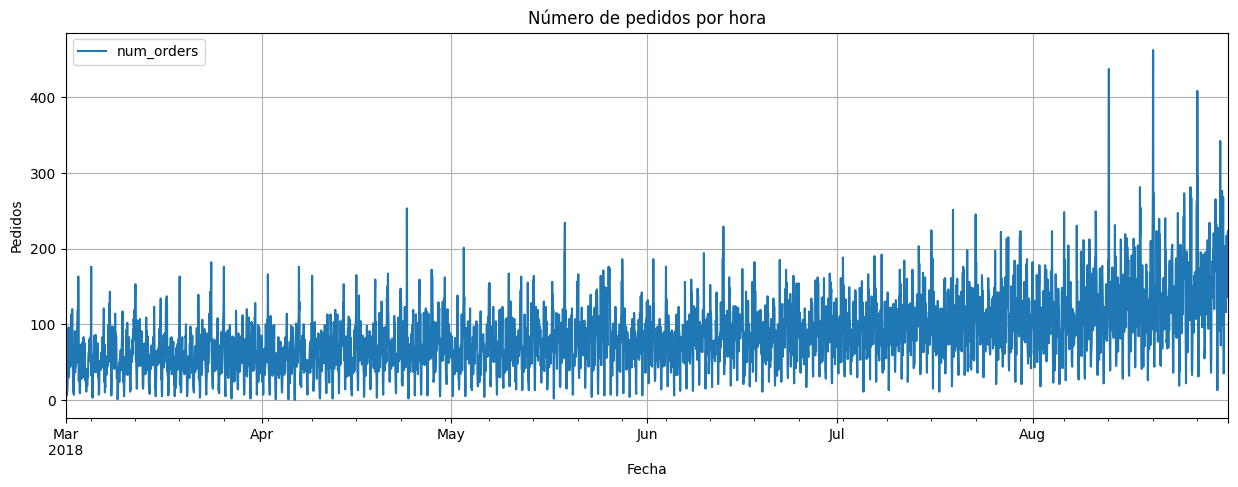

In [386]:
# Visualiza la serie temporal completa
df_hourly.plot(figsize=(15, 5), title='Número de pedidos por hora')
plt.xlabel('Fecha')
plt.ylabel('Pedidos')
plt.grid(True)
plt.show()

Pedidos de Taxi a lo Largo del Tiempo (Serie Temporal)

Observación: Se observa una tendencia al alza en la demanda de taxis a lo largo del tiempo. Además, hay un patrón estacional, con picos y valles que se repiten.

La demanda de taxis está creciendo en general, y existen patrones estacionales que probablemente se deban a factores como la hora del día, el día de la semana o eventos especiales.

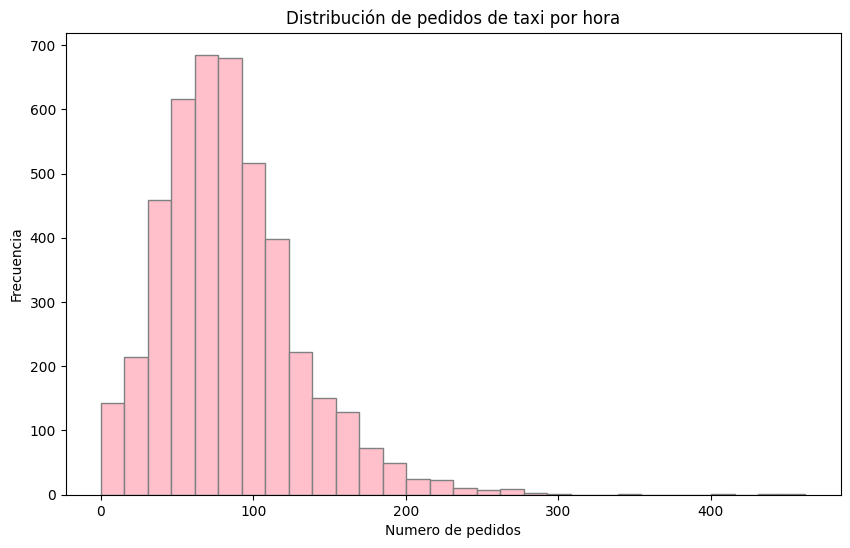

In [387]:
# Distribución de pedidos de taxi por hora.
plt.figure(figsize=(10, 6))
plt.hist(df_hourly['num_orders'], bins=30, color='pink', edgecolor='gray')
plt.title('Distribución de pedidos de taxi por hora')
plt.xlabel('Numero de pedidos')
plt.ylabel('Frecuencia')
plt.show()

Distribución de Pedidos de Taxi por Hora (Histograma)

Observación: La distribución está sesgada a la derecha, lo que significa que la mayoría de las horas tienen un número relativamente bajo de pedidos, pero hay algunos picos con un número mucho mayor de pedidos.

Conclusión: La demanda de taxis no es uniforme a lo largo del día. Hay horas pico donde la demanda es significativamente mayor.

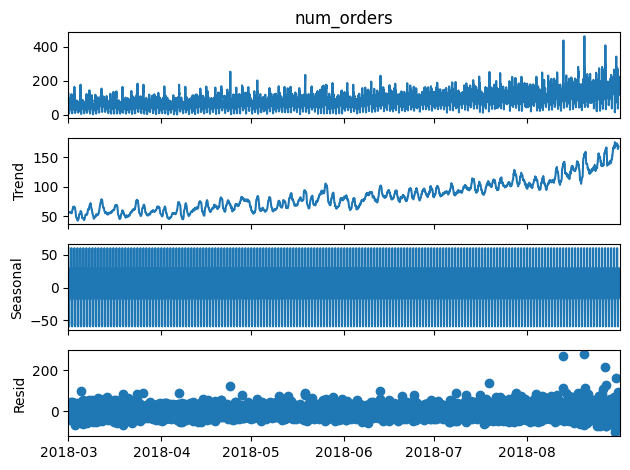

In [388]:
# Descomposición de la serie temporal. Esto ayuda a ver la tendencia, estacionalidad y residuo.
decomposition = seasonal_decompose(df_hourly['num_orders'], model='additive', period=24)
decomposition.plot()
plt.show()

Tendencia: Una tendencia al alza, confirmando el crecimiento general de la demanda de taxis que se vio en el gráfico de serie temporal original.

Estacionalidad: Un patrón estacional claro con picos durante las horas pico y valles durante las horas de menor actividad. Esto también se observó en el gráfico original.

Residuo: La aleatoriedad del residuo indicaría qué tan bien se explica la serie por la tendencia y la estacionalidad. 

In [389]:
# Estadística descriptiva 
print(df_hourly.describe())

        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


La media y la desviación estándar dan una idea de la magnitud y la variabilidad de la demanda de taxis.

La mayoría de los valores están entre 54 y 107 pedidos por hora. Desviación estándar: 45. Un valor relativamente alto: los pedidos varían bastante entre horas.

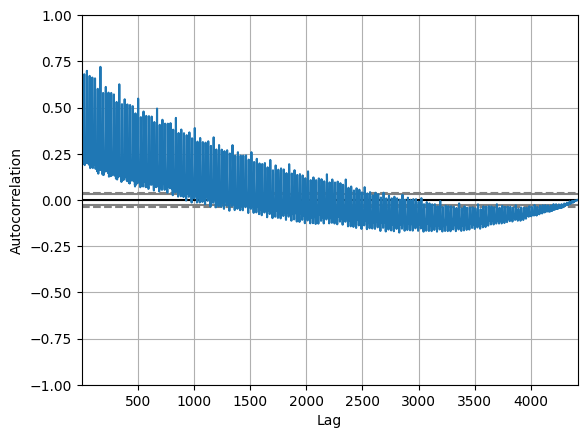

In [390]:
# Correlaciones temporales
autocorrelation_plot(df_hourly['num_orders'])
plt.show()

## Formación

In [391]:
# Crear características para el modelo.
for lag in [1, 2, 3, 6, 12]:
    df_hourly[f'lag_{lag}'] = df_hourly['num_orders'].shift(lag).ffill()

# Crear Características temporales
df_hourly['hour'] = df_hourly.index.hour
df_hourly['dayofweek'] = df_hourly.index.dayofweek
df_hourly['month'] = df_hourly.index.month
df_hourly['is_weekend'] = (df_hourly.index.dayofweek >= 5).astype(int)

# Lags (retrasos): Rolling statistics (7-day rolling mean)
df_hourly['rolling_mean_7d'] = df_hourly['num_orders'].rolling(window=7 * 24).mean().ffill()

# Ver DataFrame
display(df_hourly.head(15))

,num_orders,lag_1,lag_2,lag_3,lag_6,lag_12,hour,dayofweek,month,is_weekend,rolling_mean_7d
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,0,3,3,0,NaN
2018-03-01 01:00:00,85,124.0,NaN,NaN,NaN,NaN,1,3,3,0,NaN
2018-03-01 02:00:00,71,85.0,124.0,NaN,NaN,NaN,2,3,3,0,NaN
2018-03-01 03:00:00,66,71.0,85.0,124.0,NaN,NaN,3,3,3,0,NaN
2018-03-01 04:00:00,43,66.0,71.0,85.0,NaN,NaN,4,3,3,0,NaN
2018-03-01 05:00:00,6,43.0,66.0,71.0,NaN,NaN,5,3,3,0,NaN
2018-03-01 06:00:00,12,6.0,43.0,66.0,124.0,NaN,6,3,3,0,NaN
2018-03-01 07:00:00,15,12.0,6.0,43.0,85.0,NaN,7,3,3,0,NaN
2018-03-01 08:00:00,34,15.0,12.0,6.0,71.0,NaN,8,3,3,0,NaN


In [392]:
# Eliminar filas con valores faltantes (por los lags)
df_hourly.dropna(inplace=True)

In [393]:
# Ver DataFrame actualizado
display(df_hourly.head(15))

,num_orders,lag_1,lag_2,lag_3,lag_6,lag_12,hour,dayofweek,month,is_weekend,rolling_mean_7d
datetime,,,,,,,,,,,
2018-03-07 23:00:00,94,127.0,108.0,76.0,48.0,58.0,23,2,3,0,54.226190
2018-03-08 00:00:00,143,94.0,127.0,108.0,99.0,34.0,0,3,3,0,54.339286
2018-03-08 01:00:00,78,143.0,94.0,127.0,50.0,55.0,1,3,3,0,54.297619
2018-03-08 02:00:00,65,78.0,143.0,94.0,76.0,43.0,2,3,3,0,54.261905
2018-03-08 03:00:00,68,65.0,78.0,143.0,108.0,51.0,3,3,3,0,54.273810
2018-03-08 04:00:00,60,68.0,65.0,78.0,127.0,46.0,4,3,3,0,54.375000
2018-03-08 05:00:00,6,60.0,68.0,65.0,94.0,48.0,5,3,3,0,54.375000
2018-03-08 06:00:00,6,6.0,60.0,68.0,143.0,99.0,6,3,3,0,54.339286
2018-03-08 07:00:00,19,6.0,6.0,60.0,78.0,50.0,7,3,3,0,54.363095


# Separar en entrenamiento y prueba.

Usaremos el 90% de los datos para entrenamiento y el 10% para prueba, respetando el orden temporal


In [394]:
# Cálculo: 90% Entrenamiento, 10% Prueba
test_size = 0.1
split_index = int(len(df_hourly) * (1 - test_size))

# Características (X) y objetivo (y)
X = df_hourly.drop('num_orders', axis=1)
y = df_hourly['num_orders']

# Dividir sin desordenar (último 10% como prueba)
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

# Verificar conjunto de datos y tipo de índice
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("X_train index type:", X_train.index.dtype)
print("X_test index type:", X_test.index.dtype)

X_train shape: (3824, 10)
X_test shape: (425, 10)
y_train shape: (3824,)
y_test shape: (425,)
X_train index type: datetime64[ns]
X_test index type: datetime64[ns]


# Entrenamiento de modelos

* Regresión lineal.

In [395]:
# Entrenar modelo
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predecir
y_pred = lr_model.predict(X_test)

# Calcular RECM
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f'RECM del modelo: {rmse:.2f}')

RECM del modelo: 50.08


RECM del modelo: 50.08 es alto. No cumple con el objetivo del proyecto que es un RECM menor a 48.
La regresión lineal no fue suficiente para capturar la complejidad de la serie temporal.

* Random Forest

In [396]:
# Entrenar modelo
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predecir
rf_pred = rf_model.predict(X_test)

# Calcular RECM
rf_rmse = sqrt(mean_squared_error(y_test, rf_pred))
print(f'RECM Random Forest: {rf_rmse:.2f}')


RECM Random Forest: 44.58


El modelo Random Forest: RECM = 44.58 sí cumple con el objetivo al ser menor a 48.

* Gradient Boosting (XGBoost)

In [397]:
# Entrenar modelo
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Predecir
xgb_pred = xgb_model.predict(X_test)

# Calcular RECM
xgb_rmse = sqrt(mean_squared_error(y_test, xgb_pred))
print(f'RECM XGBoost: {xgb_rmse:.2f}')

RECM XGBoost: 47.08


XGBoost también logró estar por debajo del umbral con 47.08, lo que lo convierte en una buena alternativa si buscamos mayor interpretabilidad de errores.

# Búsquedad de mejores hiperparámetros

In [398]:
# Definir el modelo base
rf = RandomForestRegressor(random_state=42)

# Definir la grilla de hiperparámetros a probar
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,  # validación cruzada de 3 pliegues
    scoring='neg_root_mean_squared_error',  # inverso de RECM
    n_jobs=-1,  # usar todos los núcleos
    verbose=2
)

# Ejecutar la búsqueda
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Evaluar en el conjunto de prueba
best_rf_model = grid_search.best_estimator_
rf_pred = best_rf_model.predict(X_test)

rf_rmse = sqrt(mean_squared_error(y_test, rf_pred))
print(f'RECM con modelo optimizado: {rf_rmse:.2f}')


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Mejores hiperparámetros encontrados:
{'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
RECM con modelo optimizado: 43.10


In [399]:
# Modelo base
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Definir la grilla de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# Ejecutar la búsqueda
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Evaluar en el conjunto de prueba
best_xgb_model = grid_search.best_estimator_
xgb_pred = best_xgb_model.predict(X_test)

xgb_rmse = sqrt(mean_squared_error(y_test, xgb_pred))
print(f'RECM con modelo XGBoost optimizado: {xgb_rmse:.2f}')


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mejores hiperparámetros encontrados:
{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
RECM con modelo XGBoost optimizado: 44.94


XGBoost optimizado: 44.94 también cumple con el objetivo de ser menor a 48. Sin embargo, El modelo Random Forest optimizado es el mejor de todos los evaluados, con un RECM de 43.10.

# Conclusiones:

Para abordar el desafío de Sweet Lift Taxi de atraer conductores durante las horas pico, se desarrolló un modelo de predicción de la demanda de taxis. Después de evaluar varios modelos, incluyendo Linear Regression y XGBoost, el modelo Random Forest optimizado con GridSearchCV logró el mejor desempeño, con un RECM de 43.10, cumpliendo con el objetivo del proyecto de un RECM menor que 48.

Este modelo permitirá a Sweet Lift Taxi anticipar la demanda y optimizar la asignación de conductores, ajustando las tarifas dinámicamente y asegurando una mejor disponibilidad de taxis durante las horas pico. Como resultado, la compañía podrá aumentar la satisfacción del cliente, mejorar la eficiencia operativa y, potencialmente, aumentar sus ingresos.

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48